In [0]:
pip install textblob

Python interpreter will be restarted.
Python interpreter will be restarted.


In [0]:
pip install wordcloud

Python interpreter will be restarted.
Python interpreter will be restarted.


In [0]:
pip install s3fs

Python interpreter will be restarted.
  Attempting uninstall: botocore
    Found existing installation: botocore 1.24.32
    Not uninstalling botocore at /databricks/python3/lib/python3.9/site-packages, outside environment /local_disk0/.ephemeral_nfs/envs/pythonEnv-1cda804e-727b-47e4-b7b2-392861216354
    Can't uninstall 'botocore'. No files were found to uninstall.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
boto3 1.21.32 requires botocore<1.25.0,>=1.24.32, but you have botocore 1.33.1 which is incompatible.
Python interpreter will be restarted.


In [0]:
import os
# To work with Amazon S3 storage, set the following variables using your AWS Access Key and Secret Key
# Set the Region to where your files are stored in S3.
#access_key =
#secret_key =
# Set the environment variables so boto3 can pick them up later
os.environ['AWS_ACCESS_KEY_ID'] = access_key
os.environ['AWS_SECRET_ACCESS_KEY'] = secret_key
encoded_secret_key = secret_key.replace("/", "%2F")
aws_region = "us-east-2"
# Update the Spark options to work with our AWS Credentials
sc._jsc.hadoopConfiguration().set("fs.s3a.access.key", access_key)
sc._jsc.hadoopConfiguration().set("fs.s3a.secret.key", secret_key)
sc._jsc.hadoopConfiguration().set("fs.s3a.endpoint", "s3." + aws_region +
".amazonaws.com")

In [0]:
# Reading From Raw Folder
yelp_parquet = 's3a://yelp-reviews-jb/raw/yelp_dataset.parquet/'
yelp_sdf2 = spark.read.parquet(yelp_parquet)

In [0]:
columns_to_drop = ['cool',  'date',  'funny',  'review_id', 'useful',  'business_address',  'business_categories', 'hours',
  'business_name',  'user_compliment_cute',  'user_compliment_hot', 'user_compliment_list', 'user_compliment_more',
 'user_compliment_note',  'user_compliment_photos',  'user_compliment_plain',  'user_compliment_profile',  'user_compliment_writer',  'user_cool',
 'user_elite',    'user_friends',  'user_funny',  'user_name', 'user_yelping_since' ]

yelp_sdf2 = yelp_sdf2.drop(*columns_to_drop)

In [0]:
yelp_sdf2 = yelp_sdf2.sample(False, 0.01)

In [0]:
yelp_sdf2.count()

Out[5]: 64564

In [0]:
# StringIndexing to convert categorical variables to numeric indices 

from pyspark.ml.feature import StringIndexer
indexer = StringIndexer(inputCols=["business_id", "city", "state"], outputCols=["business_id_index", "city_index", "state_index"], handleInvalid="keep")

# Apply StringIndexer
#yelp_sdf2 = indexer.fit(yelp_sdf2).transform(yelp_sdf2)

In [0]:
# OneHotEncoding to convert categorical variables to binary vectors
from pyspark.ml.feature import OneHotEncoder

# Using indexed columns as input because OneHotEncoder expects numerical inputs
# Outputs are stored in outputCols as binary vectors 
encoder = OneHotEncoder(inputCols=["business_id_index", "city_index", "state_index"], outputCols=["business_id_vector", "city_vector", "state_vector"], dropLast=True, handleInvalid="keep")

# Apply OneHotEncoder
#yelp_sdf2 = encoder.fit(yelp_sdf2).transform(yelp_sdf2)

In [0]:
# Getting some statistics on the review text:

from pyspark.sql.functions import col, isnan, when, count, udf, length

# Find the length of review text
yelp_sdf2 = yelp_sdf2.withColumn("text_length", length(col("text")))
yelp_sdf2.select("text_length").summary("count", "min", "max", "mean").show()

+-------+----------------+
|summary|     text_length|
+-------+----------------+
|  count|           64564|
|    min|               6|
|    max|            5000|
|   mean|562.255080230469|
+-------+----------------+



Out[9]: <seaborn.axisgrid.FacetGrid at 0x7fd221a542e0>

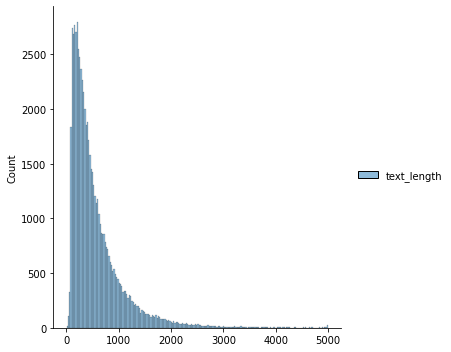

In [0]:
import seaborn as sns
# Take the length column and convert to a Pandas dataframe
df = yelp_sdf2.select('text_length').toPandas()
# Create the distribution plot
sns.displot(df)

In [0]:
# Remove records with abnormally long review text. Choose your own threshold (500, 300, etc.)
yelp_sdf2 = yelp_sdf2.where(col("text_length") <= 300 )

In [0]:
yelp_sdf2.count()

Out[11]: 23775

In [0]:
yelp_sdf2.columns

Out[12]: ['user_id',
 'business_id',
 'stars',
 'text',
 'city',
 'is_open',
 'business_review_count',
 'business_stars',
 'state',
 'user_average_stars',
 'user_compliment_cool',
 'user_compliment_funny',
 'user_fans',
 'user_review_count',
 'user_useful',
 'text_length']

In [0]:
from pyspark.ml.feature import RegexTokenizer, HashingTF, IDF
# Performing in-line rather than making part of the pipeline

tokenizer = RegexTokenizer(inputCol="text", outputCol="words", pattern="\\w+", gaps=False)
yelp_sdf2 = tokenizer.transform(yelp_sdf2)
hashingTF = HashingTF(numFeatures=4096, inputCol="words", outputCol="word_features")
yelp_sdf2 = hashingTF.transform(yelp_sdf2)
idf = IDF(inputCol='word_features', outputCol="idf_features", minDocFreq=1)
idfModel = idf.fit(yelp_sdf2)
yelp_sdf2 = idfModel.transform(yelp_sdf2)

In [0]:
# Text Engineering - Textblob for sentiment analysis
from textblob import TextBlob
from pyspark.sql.functions import udf
from pyspark.sql.types import DoubleType

# Using TextBlob for Sentiment Analysis
def sentiment_analysis(some_text):
    sentiment = TextBlob(some_text).sentiment.polarity
    return sentiment

# Defining a UDF for sentiment analysis
sentiment_analysis_udf = udf(sentiment_analysis, DoubleType())

# Applying the UDF to the "text" column and create a new column called "sentiment_score"
yelp_sdf2 = yelp_sdf2.withColumn("sentiment_score", sentiment_analysis_udf("text"))

# Examining the output
yelp_sdf2.select("text", "sentiment_score").limit(5).show(truncate=False)

+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+--------------------+
|text                                                                                                                                                                                                                                 |sentiment_score     |
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+--------------------+
|Horrible dismissive service. Carrie is a fucking bitch!!!!!!!!!! And Jim can suck a dick. I used my temporary state ID to buy liquor and food at other locations but came here to this BS and they wouldn't let me. Called corporate.|-0.53125  

In [0]:
yelp_sdf2.columns
yelp_sdf2.dtypes

Out[15]: [('user_id', 'string'),
 ('business_id', 'string'),
 ('stars', 'double'),
 ('text', 'string'),
 ('city', 'string'),
 ('is_open', 'bigint'),
 ('business_review_count', 'bigint'),
 ('business_stars', 'double'),
 ('state', 'string'),
 ('user_average_stars', 'double'),
 ('user_compliment_cool', 'bigint'),
 ('user_compliment_funny', 'bigint'),
 ('user_fans', 'bigint'),
 ('user_review_count', 'bigint'),
 ('user_useful', 'bigint'),
 ('text_length', 'int'),
 ('words', 'array<string>'),
 ('word_features', 'vector'),
 ('idf_features', 'vector'),
 ('sentiment_score', 'double')]

In [0]:
from pyspark.sql.functions import col

yelp_sdf2 = (
    yelp_sdf2
    .withColumn("business_review_count", col("business_review_count").cast("double"))
    .withColumn("is_open", col("is_open").cast("double"))
    .withColumn("user_review_count", col("user_review_count").cast("double"))
    .withColumn("user_fans", col("user_fans").cast("double"))
    .withColumn("user_compliment_cool", col("user_compliment_cool").cast("double"))
    .withColumn("user_compliment_funny", col("user_compliment_funny").cast("double"))
    .withColumn("user_useful", col("user_useful").cast("double"))
)

In [0]:
# Using VectorAssembler to combine our individual feature vectors into one large vector

from pyspark.ml.feature import VectorAssembler
assembler = VectorAssembler(inputCols=["city_vector", "state_vector", "word_features", "idf_features", "sentiment_score", "business_review_count", "business_stars", "is_open",
    "user_average_stars", "user_review_count", "user_fans",
    "user_compliment_cool", "user_compliment_funny", "user_useful"],
outputCol="features")

In [0]:
#yelp_sdf2 = assembler.transform(yelp_sdf2)

In [0]:
yelp_sdf2.columns

Out[19]: ['user_id',
 'business_id',
 'stars',
 'text',
 'city',
 'is_open',
 'business_review_count',
 'business_stars',
 'state',
 'user_average_stars',
 'user_compliment_cool',
 'user_compliment_funny',
 'user_fans',
 'user_review_count',
 'user_useful',
 'text_length',
 'words',
 'word_features',
 'idf_features',
 'sentiment_score']

In [0]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import Binarizer
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator, RegressionEvaluator

In [0]:
# Binarize the 'stars' column
# Creating a binary label (0 or 1) where 0 indicates a star rating <= 3, and 1 indicates a star rating > 3
binarizer = Binarizer(threshold=3.0, inputCol='stars', outputCol='label')
yelp_sdf2 = binarizer.transform(yelp_sdf2)

print("Binarizer output with Threshold", binarizer.getThreshold())

# Select the columns you want to display
binary_label_df = yelp_sdf2.select("user_id", "stars", "label")

# Show the resulting DataFrame
binary_label_df.show()

Binarizer output with Threshold 3.0
+--------------------+-----+-----+
|             user_id|stars|label|
+--------------------+-----+-----+
|-yrqsIGkhDJ3mDARW...|  1.0|  0.0|
|07YMTWICItcVg1UPW...|  1.0|  0.0|
|1mP2IJwlQgxm5P3Gi...|  5.0|  1.0|
|1rPlm6liFDqv8oSmu...|  3.0|  0.0|
|2Q5LQRSHSLBK-twOB...|  5.0|  1.0|
|2yd4J-ieLWK_FNiaA...|  5.0|  1.0|
|3Kbr90iDnNxVOr1EB...|  5.0|  1.0|
|4LQ8YxuHI__oBdh4H...|  5.0|  1.0|
|4Mljx6AvGKt91n2Sc...|  5.0|  1.0|
|4tkkDeJ9pAMfrsj92...|  4.0|  1.0|
|4uHX13suzYG4TWhAK...|  1.0|  0.0|
|69rCSSQjFihK7FJ-6...|  4.0|  1.0|
|6Raja_0G0mfCaaaqb...|  5.0|  1.0|
|7-8mh-ibzd7OmFMSB...|  5.0|  1.0|
|7898uuJ-YKlXDtYYL...|  4.0|  1.0|
|7JWIy_HgKQja6BNBr...|  5.0|  1.0|
|7tZ4TUgyJ8o_FlbHD...|  5.0|  1.0|
|8LdWRyDwO4K-cmjh1...|  4.0|  1.0|
|8XeTv8Js_8um5Ht1Q...|  5.0|  1.0|
|8Z2Y4FjxzcYRxbpOI...|  5.0|  1.0|
+--------------------+-----+-----+
only showing top 20 rows



In [0]:
# Create a LogisticRegression Estimator
lr = LogisticRegression(featuresCol='features', labelCol='label')

In [0]:
# Split the data into training and test sets
trainingData, testData = yelp_sdf2.randomSplit([0.70, 0.30], seed=42)

In [0]:
# Create the pipeline
pipeline = Pipeline(stages=[indexer, encoder, assembler, lr])

In [0]:
# Train the model on the trainingData
model = pipeline.fit(trainingData)

In [0]:
# Save the model to the "/models" folder
#model.write().overwrite().save("s3a://yelp-reviews-jb/models/lr_model")

In [0]:
# Show the model coefficients and intercept
lr_model = model.stages[-1]
coefficients = lr_model.coefficients
intercept = lr_model.intercept

print("Coefficients: ", coefficients)
print("Intercept: ", intercept)

Coefficients:  [1.0223132699988418,-4.993861309284238,-8.215673792226857,-0.45565495181630766,-1.3516925029567215,-0.8927911333563745,3.3833825464313563,2.2668884013655064,-3.0404665573669885,1.7566320628598093,-24.97073219608834,20.57246661070442,-2.1604339461669646,-27.74790360420444,-7.42418498447403,11.44622310506997,4.520573405279022,-3.6675408744159665,42.893573109178895,16.943814279669613,-21.7332791354642,-21.21532603250168,-1.1249068030261773,-29.575604840485507,38.85745626032495,3.878289129125391,57.05945451496216,9.785353384449737,44.86166520353749,65.23914654669947,-55.3509874946143,25.41261912018567,-53.29028308550333,-18.407585126435226,7.958457364218631,-0.03471828546462369,-33.35631064153074,-35.536767363997285,47.04924303576243,-19.55798643923221,-12.36898008980825,-38.83200374068259,-2.472777242714155,13.624908218642974,-30.39508676616955,52.180330922380996,-16.580131601163195,-89.38847875248186,12.696540935169073,-45.565393379196045,20.490612672323152,-12.68584524885

In [0]:
# Testing the model on the testData
predictions = model.transform(testData)

# Writing Transformed Data To Trusted Folder
#predictions.write.mode("overwrite").parquet("s3a://yelp-reviews-jb/trusted/predictions.parquet")

In [0]:
# Create a BinaryClassificationEvaluator to evaluate how well the model works
evaluator = BinaryClassificationEvaluator(metricName="areaUnderROC")
# Calculate AUC
auc = evaluator.evaluate(predictions)
print(f"AUC: {auc}")

AUC: 0.8826827362615657


In [0]:
# Create the confusion matrix
predictions.groupby('label').pivot('prediction').count().fillna(0).show()
cm = predictions.groupby('label').pivot('prediction').count().fillna(0).collect()

def calculate_recall_precision(cm):
    tn = cm[0][1]                # True Negative
    fp = cm[0][2]                # False Positive
    fn = cm[1][1]                # False Negative
    tp = cm[1][2]                # True Positive
    precision = tp / ( tp + fp )            
    recall = tp / ( tp + fn )
    accuracy = ( tp + tn ) / ( tp + tn + fp + fn )
    f1_score = 2 * ( ( precision * recall ) / ( precision + recall ) )
    return accuracy, precision, recall, f1_score

print("Accuracy, Precision, Recall, F1 Score")
print( calculate_recall_precision(cm))

+-----+----+----+
|label| 0.0| 1.0|
+-----+----+----+
|  0.0|1240| 470|
|  1.0| 592|4767|
+-----+----+----+

Accuracy, Precision, Recall, F1 Score
(0.849766586504456, 0.9102539621920948, 0.8895316290352677, 0.8997734994337485)


In [0]:
import seaborn as sns
import io
import matplotlib.pyplot as plt
import s3fs  # Import the s3fs library
from sklearn.metrics import roc_curve, auc

# Extract probability values from DenseVector
y_scores = predictions.select("probability").toPandas()['probability'].apply(lambda x: x[1])

# Assuming 'label' is your true labels
y_true = predictions.select("label").toPandas()

fpr, tpr, _ = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='best')

# Create a BytesIO object to save the plot
img_data = io.BytesIO()
plt.savefig(img_data, format='png', bbox_inches='tight')
plt.close()  # Close the plot to avoid displaying it

# Connect to the s3fs file system 
s3 = s3fs.S3FileSystem(anon=False)

# Open the file for writing
with s3.open('s3://yelp-reviews-jb/my_plot.png', 'wb') as f:
    f.write(img_data.getbuffer())

/databricks/spark/python/pyspark/sql/pandas/conversion.py:122: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  Unable to convert the field probability. If this column is not necessary, you may consider dropping it or converting to primitive type before the conversion.
Direct cause: Unsupported type in conversion to Arrow: VectorUDT()
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)


/databricks/spark/python/pyspark/sql/pandas/conversion.py:122: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  Unable to convert the field probability. If this column is not necessary, you may consider dropping it or converting to primitive type before the conversion.
Direct cause: Unsupported type in conversion to Arrow: VectorUDT()
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)


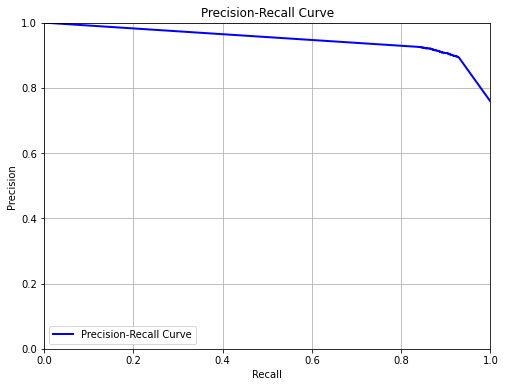

In [0]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
from pyspark.sql import SparkSession
from pyspark.sql.functions import col

# 'label' is your true labels
y_true = predictions.select("label").toPandas()

# Extract probability values from DenseVector
y_scores = predictions.select("probability").toPandas()['probability'].apply(lambda x: x[1])

# Calculate precision and recall
precision, recall, _ = precision_recall_curve(y_true, y_scores)

# Plot the precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.grid(True)
plt.legend(loc='best')
plt.show()

# Create a BytesIO object for the new plot
img_data2 = io.BytesIO()
plt.savefig(img_data2, format='png', bbox_inches='tight')
plt.close()  # Close the plot to avoid displaying it

# Connect to the s3fs file system 
s3 = s3fs.S3FileSystem(anon=False)

# Open the file for writing with a different name
with s3.open('s3://yelp-reviews-jb/my_plot_new.png', 'wb') as f:
    f.write(img_data2.getbuffer())